In [1]:
# Setup
import os
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH = '/content/drive/MyDrive/yelp-rating-prediction'
SYM_PATH = '/content/yelp-rating-prediction'
# Sym link
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

%cd drive/MyDrive/yelp-rating-prediction
!pip install -r requirements.txt
%cd src

Mounted at /content/drive
/content/drive/MyDrive/yelp-rating-prediction
     |████████████████████████████████| 3.3MB 6.9MB/s 
     |████████████████████████████████| 2.1MB 40.2MB/s 
     |████████████████████████████████| 2.1MB 36.0MB/s 
     |████████████████████████████████| 901kB 38.9MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 133kB 8.1MB/s 
     |████████████████████████████████| 163kB 39.0MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=ff44c314c41c8395201b1c6fc98f052f76f9d4cf421f89fd9b1fe8521b18b54b
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=7b820caf77c46882468a9137815f94c2672818d955d0216224aa070b91ba2f2e
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b

In [3]:
!head -n 2 ../yelp_dataset/review_sample.json

{"review_id": "E3Bgem6OsV3LpOFe5ZVcEg", "user_id": "MbSOC7w1rIsMglmNn8Fkmw", "business_id": "SfkRN960vVQ74mbowSEuXQ", "stars": 5.0, "useful": 0, "funny": 0, "cool": 0, "text": "Affordable prices, fast service, and a friendly dog named Rambo. This place is great.", "date": "2019-01-03 04:12:41"}
{"review_id": "a7KaN1Li94o1au_8BfNi3Q", "user_id": "p_16faRfE0DYJolk7_MfHw", "business_id": "YZs1gNSh_sN8JmN_nrpxeA", "stars": 5.0, "useful": 0, "funny": 0, "cool": 0, "text": "One of my favorite BBQ places in town. The meats and the sides are both fantastic, it doesn't smell like your table is located inside the smoker, and the noise level is manageable. Highly recommended.", "date": "2019-01-10 22:14:40"}


In [ ]:
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from utils import RATINGS, ratings_to_labels

In [ ]:
def plot_confusion_matrix(confusion_matrix):
  df_cm = pd.DataFrame(confusion_matrix, index = RATINGS, columns = RATINGS)
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=True)

In [ ]:
data_file = "../yelp_dataset/review_sample.json"
df = pd.read_json(data_file, lines=True)
print(df.head())

                review_id  ...                date
0  E3Bgem6OsV3LpOFe5ZVcEg  ... 2019-01-03 04:12:41
1  a7KaN1Li94o1au_8BfNi3Q  ... 2019-01-10 22:14:40
2  L1KF9DFOKjW5MhKstPzheg  ... 2019-01-10 01:25:05
3  UrmQiUUZb2qhmBtfqlJNRQ  ... 2019-01-14 17:54:56
4  nbByX4lN7Dds-nXF4GuLxg  ... 2019-01-01 00:54:29

[5 rows x 9 columns]


In [ ]:
df.drop(columns=['useful', 'funny', 'cool'], inplace=True)
print(df.head())

                review_id  ...                date
0  E3Bgem6OsV3LpOFe5ZVcEg  ... 2019-01-03 04:12:41
1  a7KaN1Li94o1au_8BfNi3Q  ... 2019-01-10 22:14:40
2  L1KF9DFOKjW5MhKstPzheg  ... 2019-01-10 01:25:05
3  UrmQiUUZb2qhmBtfqlJNRQ  ... 2019-01-14 17:54:56
4  nbByX4lN7Dds-nXF4GuLxg  ... 2019-01-01 00:54:29

[5 rows x 6 columns]


In [ ]:
df.iloc[0]

review_id                                 E3Bgem6OsV3LpOFe5ZVcEg
user_id                                   MbSOC7w1rIsMglmNn8Fkmw
business_id                               SfkRN960vVQ74mbowSEuXQ
stars                                                          5
text           Affordable prices, fast service, and a friendl...
date                                         2019-01-03 04:12:41
Name: 0, dtype: object

Accuracy: 0.2000972729718318


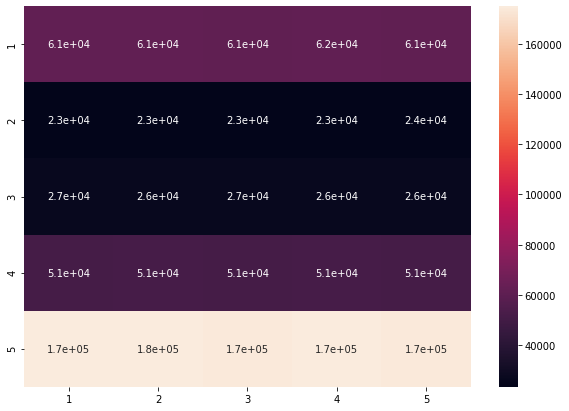

In [ ]:
# Baseline 1: Random predictions
np.random.seed(24)
preds = np.random.choice(5, size=len(df))    # 5 possible ratings
print(f"Accuracy: {accuracy_score(ratings_to_labels(df['stars']), preds)}")
plot_confusion_matrix(confusion_matrix(ratings_to_labels(df['stars']), preds))

Accuracy: 0.35104794108512216


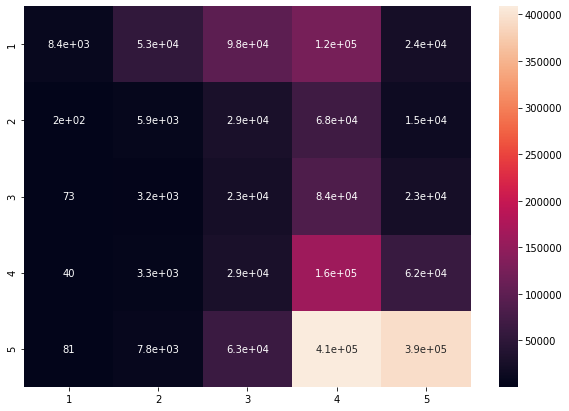

In [ ]:
# Baseline 2: Restaurant Rating (rounded up)
ratings = pd.read_json("../yelp_dataset/business.json", lines=True)
ratings = ratings[['business_id', 'stars']]
ratings.set_index('business_id', inplace=True)
ratings.rename(columns={'stars':'avg_stars'}, inplace=True)
pred_stars = np.ceil(df.merge(ratings, how='left', left_on='business_id', right_index=True)['avg_stars'])
print(f"Accuracy: {accuracy_score(ratings_to_labels(df['stars']), ratings_to_labels(pred_stars))}")
plot_confusion_matrix(confusion_matrix(ratings_to_labels(df['stars']), ratings_to_labels(pred_stars)))

Accuracy: 0.21517577130993676


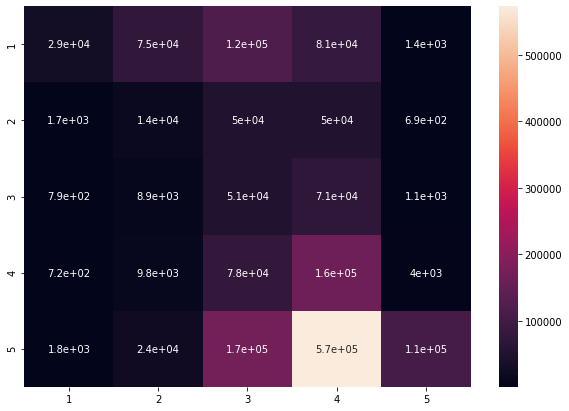

In [ ]:
# Baseline 3: Restaurant Rating (rounded down)
ratings = pd.read_json("../yelp_dataset/business.json", lines=True)
ratings = ratings[['business_id', 'stars']]
ratings.set_index('business_id', inplace=True)
ratings.rename(columns={'stars':'avg_stars'}, inplace=True)
pred_stars = np.floor(df.merge(ratings, how='left', left_on='business_id', right_index=True)['avg_stars'])
print(f"Accuracy: {accuracy_score(ratings_to_labels(df['stars']), ratings_to_labels(pred_stars))}")
plot_confusion_matrix(confusion_matrix(ratings_to_labels(df['stars']), ratings_to_labels(pred_stars)))

In [ ]:
# Baseline 4: Average User Rating (rounded)
users = pd.read_json("../yelp_dataset/user.json", lines=True)
users = users[['user_id', 'average_stars']]
users.set_index('user_id', inplace=True)
pred_stars = np.round(df.merge(users, how='left', left_on='user_id', right_index=True)['average_stars'])
print(f"Accuracy: {accuracy_score(ratings_to_labels(df['stars']), ratings_to_labels(pred_stars))}")
plot_confusion_matrix(confusion_matrix(ratings_to_labels(df['stars']), ratings_to_labels(pred_stars)))